In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
!pip install umap-learn
import umap
!pip install optuna
import optuna
import xgboost as xgb
import functools
import lightgbm as lgb
import time
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')

In [ ]:
api_token = {"username":"watsons","key":"dc7da47ca9aa5e696b65f97c16fd627b"}
import json
import zipfile
import os
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
!kaggle competitions download -c titanic

In [109]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('gender_submission.csv')

In [110]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [111]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [112]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [113]:
y=train['Survived']
train.drop(['Survived'],inplace=True,axis=1)

檢視train,test變數分布上是否有明顯差異，除Embarked比例差距較大，其餘較無差異，因此在此將其合併處理

In [114]:
print(train['Embarked'].value_counts(normalize=True))
test['Embarked'].value_counts(normalize=True)

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64


S    0.645933
C    0.244019
Q    0.110048
Name: Embarked, dtype: float64

In [115]:
print(train['Sex'].value_counts(normalize=True))
test['Sex'].value_counts(normalize=True)

male      0.647587
female    0.352413
Name: Sex, dtype: float64


male      0.636364
female    0.363636
Name: Sex, dtype: float64

In [116]:
print(train[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']].describe())
print(test[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']].describe())

           Pclass         Age       SibSp       Parch        Fare
count  891.000000  714.000000  891.000000  891.000000  891.000000
mean     2.308642   29.699118    0.523008    0.381594   32.204208
std      0.836071   14.526497    1.102743    0.806057   49.693429
min      1.000000    0.420000    0.000000    0.000000    0.000000
25%      2.000000   20.125000    0.000000    0.000000    7.910400
50%      3.000000   28.000000    0.000000    0.000000   14.454200
75%      3.000000   38.000000    1.000000    0.000000   31.000000
max      3.000000   80.000000    8.000000    6.000000  512.329200
           Pclass         Age       SibSp       Parch        Fare
count  418.000000  332.000000  418.000000  418.000000  417.000000
mean     2.265550   30.272590    0.447368    0.392344   35.627188
std      0.841838   14.181209    0.896760    0.981429   55.907576
min      1.000000    0.170000    0.000000    0.000000    0.000000
25%      1.000000   21.000000    0.000000    0.000000    7.895800
50%      3

In [117]:
train_test=pd.concat([train,test])
train_test['title']=0
train_test['title']=train_test.Name.str.extract('([A-Za-z]+)\.')

train_test['title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr','Mrs'],inplace=True)
train_test.title.value_counts()

Mr        770
Miss      265
Mrs       200
Master     61
Other      13
Name: title, dtype: int64

In [118]:
train_test['last']=0
train_test['last']=train_test.Name.str.extract('([A-Za-z]+),')
bigsave=[]
for idx,name in enumerate(train_test['last']):
  save=[]
  for idx2,name2 in enumerate(train_test['last'][:891]):
    if(idx!=idx2 and name==name2):
      save.append(y[idx2])
  bigsave.append(np.mean(save))

train_test['family_live']=bigsave
train_test['family_na']=[1 if i==True else 0 for i in train_test['family_live'].isnull()]
train_test['family_live'].fillna(0,inplace=True)

In [119]:
train_test['preticket'] = [str(len(i)) if i[0].isdigit() else i[:1] for i in train_test['Ticket']]
train_test['preticket'].value_counts()

6    596
5    193
4    144
S     98
P     98
C     77
A     42
7     20
W     19
F     13
L      5
3      4
Name: preticket, dtype: int64

In [120]:
train_test['Cabin'].fillna('M',inplace=True)
train_test['Cabin_ini']=[i[0] for i in train_test['Cabin']]
train_test['Cabin_ini'].value_counts()

M    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin_ini, dtype: int64

In [121]:
train_test.drop(['Cabin','Name','Ticket'],inplace=True,axis=1)
train_test.set_index(['PassengerId'],inplace=True,drop=True)

In [122]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       1309 non-null   int64  
 1   Sex          1309 non-null   object 
 2   Age          1046 non-null   float64
 3   SibSp        1309 non-null   int64  
 4   Parch        1309 non-null   int64  
 5   Fare         1308 non-null   float64
 6   Embarked     1307 non-null   object 
 7   title        1309 non-null   object 
 8   last         1309 non-null   object 
 9   family_live  1309 non-null   float64
 10  family_na    1309 non-null   int64  
 11  preticket    1309 non-null   object 
 12  Cabin_ini    1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 143.2+ KB


In [123]:
train_test_int=train_test[['SibSp','Parch','Fare','Age','family_live']]
train_test_cat=train_test[['Pclass','Sex','title','preticket','Cabin_ini','family_na']]
train_test_cat_tran=pd.DataFrame(preprocessing.OrdinalEncoder().fit_transform(train_test_cat),columns=train_test_cat.columns,index=train_test.index)
train_test_tran=pd.concat([train_test_int,train_test_cat_tran,train_test['Embarked']],axis=1)
train_test_tran.columns=['SibSp','Parch','Fare','Age','family_live','Pclass','Sex','title','preticket','Cabin_ini','family_na','Embarked']
train_test_tran

,SibSp,Parch,Fare,Age,family_live,Pclass,Sex,title,preticket,Cabin_ini,family_na,Embarked
PassengerId,,,,,,,,,,,,
1,1,0,7.2500,22.0,0.0,2.0,1.0,2.0,5.0,7.0,0.0,S
2,1,0,71.2833,38.0,0.0,0.0,0.0,3.0,9.0,2.0,1.0,C
3,0,0,7.9250,26.0,0.0,2.0,0.0,1.0,10.0,7.0,1.0,S
4,1,0,53.1000,35.0,0.0,0.0,0.0,3.0,3.0,2.0,0.0,S
5,0,0,8.0500,35.0,1.0,2.0,1.0,2.0,3.0,7.0,0.0,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1305,0,0,8.0500,NaN,0.0,2.0,1.0,2.0,5.0,7.0,1.0,S
1306,0,0,108.9000,39.0,0.0,0.0,0.0,3.0,9.0,2.0,1.0,C
1307,0,0,7.2500,38.5,0.0,2.0,1.0,2.0,10.0,7.0,1.0,S


In [124]:
imputer_test=train_test_tran[train_test_tran['Embarked'].isnull()]
imputer_train=train_test_tran[train_test_tran['Embarked'].notnull()]
imputer_test.drop(['Embarked'],inplace=True,axis=1)
imputer_y=preprocessing.LabelEncoder().fit_transform(imputer_train['Embarked'])
imputer_train.drop(['Embarked'],axis=1,inplace=True)
lgbm=lgb.LGBMClassifier()
lgbm.fit(imputer_train,imputer_y)
out=lgbm.predict(imputer_test)

In [125]:
train_test_tran['Embarked'].fillna('S',inplace=True)
train_test_tran['Embarked']=preprocessing.LabelEncoder().fit_transform(train_test_tran['Embarked'])

In [126]:
imputer_test=train_test_tran[train_test_tran['Fare'].isnull()]
imputer_train=train_test_tran[train_test_tran['Fare'].notnull()]
imputer_test.drop(['Fare'],inplace=True,axis=1)
imputer_y=imputer_train['Fare']
imputer_train.drop(['Fare'],axis=1,inplace=True)
lgbm=lgb.LGBMRegressor()
lgbm.fit(imputer_train,imputer_y)
out=lgbm.predict(imputer_test)
train_test_tran['Fare'][train_test_tran['Fare'].isnull()]=list(out)

In [127]:
train_test_tran.groupby('title')['Age'].median()
train_test_tran['age_na']=[1 if i==True else 0 for i in train_test_tran['Age'].isnull()]

使用name中的稱謂作為區隔填補年齡的na

In [128]:
for i in range(5):
  train_test_tran.loc[(train_test_tran.Age.isnull())&(train_test_tran.title==i),'Age']=train_test_tran.groupby('title')['Age'].median()[i]

In [129]:
train_test_tran.isnull().sum()

SibSp          0
Parch          0
Fare           0
Age            0
family_live    0
Pclass         0
Sex            0
title          0
preticket      0
Cabin_ini      0
family_na      0
Embarked       0
age_na         0
dtype: int64

In [130]:
train_test_tran['age_bin']=pd.cut(train_test_tran.Age,bins=5,labels=[i for i in range(5)])

In [131]:
train_test_tran

,SibSp,Parch,Fare,Age,family_live,Pclass,Sex,title,preticket,Cabin_ini,family_na,Embarked,age_na,age_bin
PassengerId,,,,,,,,,,,,,,
1,1,0,7.2500,22.0,0.0,2.0,1.0,2.0,5.0,7.0,0.0,2,0,1
2,1,0,71.2833,38.0,0.0,0.0,0.0,3.0,9.0,2.0,1.0,0,0,2
3,0,0,7.9250,26.0,0.0,2.0,0.0,1.0,10.0,7.0,1.0,2,0,1
4,1,0,53.1000,35.0,0.0,0.0,0.0,3.0,3.0,2.0,0.0,2,0,2
5,0,0,8.0500,35.0,1.0,2.0,1.0,2.0,3.0,7.0,0.0,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,0,0,8.0500,30.0,0.0,2.0,1.0,2.0,5.0,7.0,1.0,2,1,1
1306,0,0,108.9000,39.0,0.0,0.0,0.0,3.0,9.0,2.0,1.0,0,0,2
1307,0,0,7.2500,38.5,0.0,2.0,1.0,2.0,10.0,7.0,1.0,2,0,2


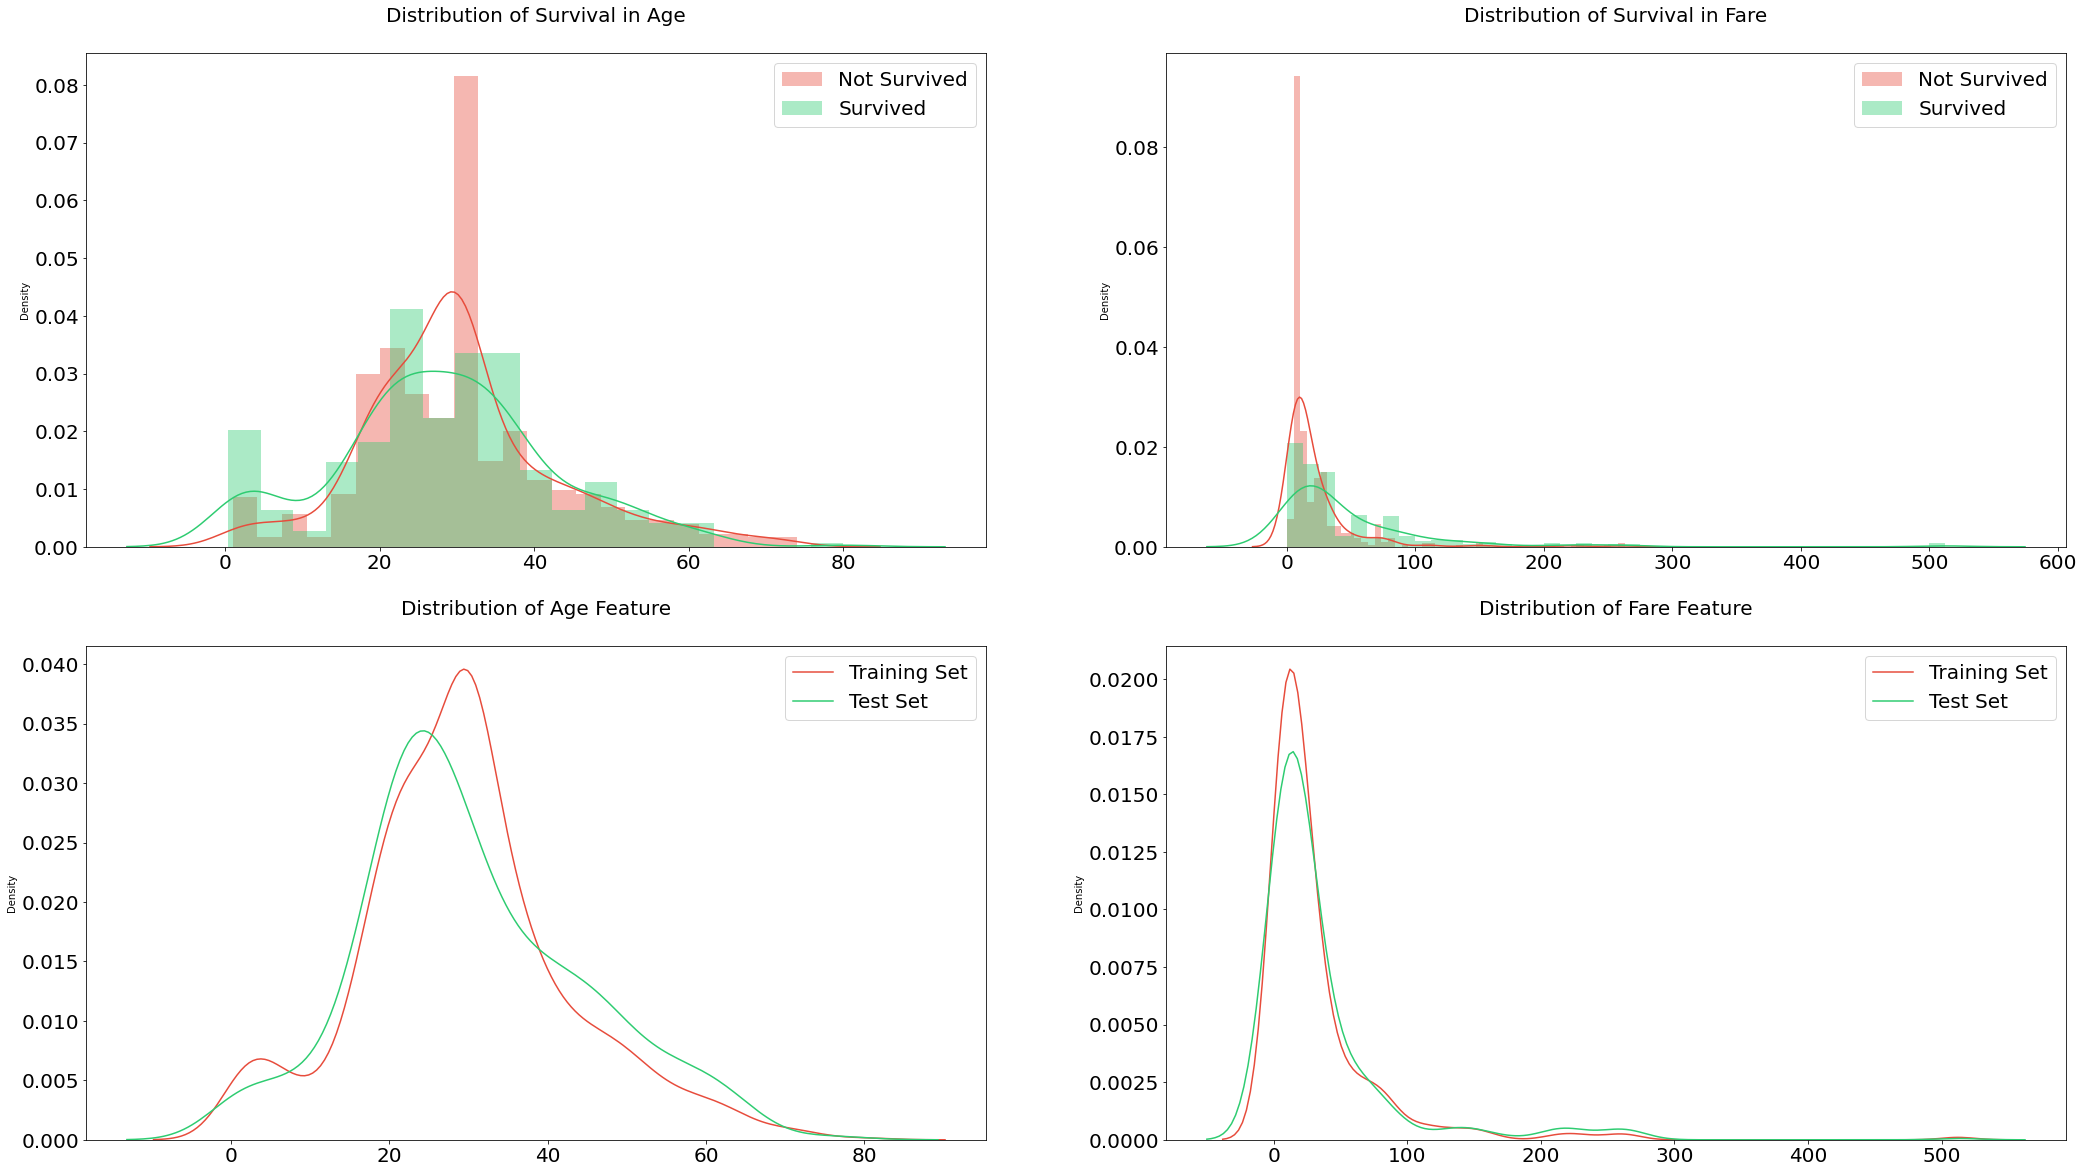

In [132]:
cont_features = ['Age', 'Fare']
te=train_test_tran[:891].reset_index(drop=True)
df_train=pd.concat([te,y],axis=1)
surv = df_train['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    sns.distplot(df_train[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=axs[0][i])
    sns.distplot(df_train[surv][feature], label='Survived', hist=True, color='#2ecc71', ax=axs[0][i])
    sns.distplot(df_train[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    sns.distplot(train_test[891:][feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1][i])

    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
plt.show()

In [133]:
train_test_tran['age_bin']=pd.cut(train_test_tran['Age'],[0,20,35,60,100],labels=[1,2,3,4])
train_test_tran['fare_bin']=[1 if i>30 else 0 for i in train_test_tran['Fare']]

In [134]:
train_test_tran['age_bin'].value_counts()

2    704
3    316
1    256
4     33
Name: age_bin, dtype: int64

In [135]:
train_test_tran['family']=train_test_tran['SibSp']+train_test_tran['Parch']
train_test_tran['family_bin']=[1 if i>0 else 0 for i in train_test_tran['family']]

In [136]:
train_test_tran

,SibSp,Parch,Fare,Age,family_live,Pclass,Sex,title,preticket,Cabin_ini,family_na,Embarked,age_na,age_bin,fare_bin,family,family_bin
PassengerId,,,,,,,,,,,,,,,,,
1,1,0,7.2500,22.0,0.0,2.0,1.0,2.0,5.0,7.0,0.0,2,0,2,0,1,1
2,1,0,71.2833,38.0,0.0,0.0,0.0,3.0,9.0,2.0,1.0,0,0,3,1,1,1
3,0,0,7.9250,26.0,0.0,2.0,0.0,1.0,10.0,7.0,1.0,2,0,2,0,0,0
4,1,0,53.1000,35.0,0.0,0.0,0.0,3.0,3.0,2.0,0.0,2,0,2,1,1,1
5,0,0,8.0500,35.0,1.0,2.0,1.0,2.0,3.0,7.0,0.0,2,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,0,0,8.0500,30.0,0.0,2.0,1.0,2.0,5.0,7.0,1.0,2,1,2,0,0,0
1306,0,0,108.9000,39.0,0.0,0.0,0.0,3.0,9.0,2.0,1.0,0,0,3,1,0,0
1307,0,0,7.2500,38.5,0.0,2.0,1.0,2.0,10.0,7.0,1.0,2,0,3,0,0,0


製造出類別變數的交乘項

In [137]:
"""
one_hot=preprocessing.OneHotEncoder()
dummy=pd.DataFrame(one_hot.fit_transform(train_test_tran[['Pclass','Sex','title','Cabin_ini','preticket','Embarked','family_bin','fare_bin','age_bin','age_na','SibSp','Parch','family','family_live','family_na']]).toarray())
dummy.columns=one_hot.get_feature_names()
the_int=train_test_tran[['Fare','Age']]
new_dummy=dummy.copy()

for i in range(len(dummy.columns)-1):
  for j in range(i+1,len(dummy.columns)):
    name=dummy.columns[i]+'*'+dummy.columns[j]
    new_dummy[name]=dummy[dummy.columns[i]]*dummy[dummy.columns[j]]

new_dummy.loc[len(new_dummy)]=new_dummy.sum(0)
new_dummy=new_dummy.T
new_dummy=new_dummy[new_dummy[1309]!=0]
new_dummy=new_dummy.T
new_dummy.drop([1309],inplace=True)

the_int.reset_index(drop=True,inplace=True)

x=pd.DataFrame()

for i in the_int.columns:
  for j in new_dummy.columns:
    name=i+'*'+j
    x[name]=the_int[i]*new_dummy[j]

x_final=pd.concat([the_int,new_dummy,x],axis=1)

"""

"\none_hot=preprocessing.OneHotEncoder()\ndummy=pd.DataFrame(one_hot.fit_transform(train_test_tran[['Pclass','Sex','title','Cabin_ini','preticket','Embarked','family_bin','fare_bin','age_bin','age_na','SibSp','Parch','family','family_live','family_na']]).toarray())\ndummy.columns=one_hot.get_feature_names()\nthe_int=train_test_tran[['Fare','Age']]\nnew_dummy=dummy.copy()\n\nfor i in range(len(dummy.columns)-1):\n  for j in range(i+1,len(dummy.columns)):\n    name=dummy.columns[i]+'*'+dummy.columns[j]\n    new_dummy[name]=dummy[dummy.columns[i]]*dummy[dummy.columns[j]]\n\nnew_dummy.loc[len(new_dummy)]=new_dummy.sum(0)\nnew_dummy=new_dummy.T\nnew_dummy=new_dummy[new_dummy[1309]!=0]\nnew_dummy=new_dummy.T\nnew_dummy.drop([1309],inplace=True)\n\nthe_int.reset_index(drop=True,inplace=True)\n\nx=pd.DataFrame()\n\nfor i in the_int.columns:\n  for j in new_dummy.columns:\n    name=i+'*'+j\n    x[name]=the_int[i]*new_dummy[j]\n\nx_final=pd.concat([the_int,new_dummy,x],axis=1)\n\n"

In [138]:
def lb_opt(xtrain,ytrain,trial):

    bagging_freq =  trial.suggest_int('bagging_freq',1,10),
    min_data_in_leaf =  trial.suggest_int('min_data_in_leaf',2,100),
    max_depth = trial.suggest_int('max_depth',1,20),
    learning_rate = trial.suggest_loguniform('learning_rate',0.001,0.1),
    num_leaves = trial.suggest_int('num_leaves',2,70),
    num_threads = trial.suggest_int('num_threads',1,10),
    min_sum_hessian_in_leaf = trial.suggest_int('min_sum_hessian_in_leaf',1,10),
    n_estimators = trial.suggest_int('n_estimators',10,500),
    min_child_samples = trial.suggest_int('n_estimators',10,30),
    reg_lambda =trial.suggest_float('reg_lambda',0.,1.)
    reg_alpha = trial.suggest_float('reg_alpha',0.,1.)
    subsample = trial.suggest_float('subsample',0.5,1.)
    colsample_bytree = trial.suggest_float('colsample_bytree',0.5,1.)
    lightgbm_tuna = lgb.LGBMClassifier(
        random_state = 0,
        verbosity = 1,
        bagging_seed = 0,
        metric = 'auc',
        min_child_samples = min_child_samples,
        reg_alpha = reg_alpha,
        reg_lambda =reg_lambda,
        bagging_freq = bagging_freq ,
        min_data_in_leaf = min_data_in_leaf,
        max_depth = max_depth,
        learning_rate = learning_rate,
        num_leaves = num_leaves,
        num_threads = num_threads,
        min_sum_hessian_in_leaf = min_sum_hessian_in_leaf,
        colsample_bytree=colsample_bytree,
        subsample = subsample
    )
    kf=KFold(n_splits=5, random_state=23, shuffle=True)
    scores = cross_val_score(lightgbm_tuna,xtrain,ytrain,scoring='accuracy',cv=kf)
    score = -round(scores.mean(),3)
    return score

In [139]:
x_train=x_final[:891]
x_test=x_final[891:]
lgbm = lgb.LGBMClassifier(max_depth=2,min_child_samples=60,subsample=0.5,colsample_bytree=0.01,reg_alpha=5,reg_lambda=5) 
lgbm.fit(x_train,y)
print(accuracy_score(lgbm.predict(x_train),y))
out=pd.DataFrame(lgbm.predict(x_test))

0.8496071829405163


檢視變數與標籤之間的關係

In [140]:
look=pd.concat([train_test_tran[:891].reset_index(drop=True),y],axis=1)
look

,SibSp,Parch,Fare,Age,family_live,Pclass,Sex,title,preticket,Cabin_ini,family_na,Embarked,age_na,age_bin,fare_bin,family,family_bin,Survived
0,1,0,7.2500,22.0,0.0,2.0,1.0,2.0,5.0,7.0,0.0,2,0,2,0,1,1,0
1,1,0,71.2833,38.0,0.0,0.0,0.0,3.0,9.0,2.0,1.0,0,0,3,1,1,1,1
2,0,0,7.9250,26.0,0.0,2.0,0.0,1.0,10.0,7.0,1.0,2,0,2,0,0,0,1
3,1,0,53.1000,35.0,0.0,0.0,0.0,3.0,3.0,2.0,0.0,2,0,2,1,1,1,1
4,0,0,8.0500,35.0,1.0,2.0,1.0,2.0,3.0,7.0,0.0,2,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,13.0000,27.0,0.0,1.0,1.0,4.0,3.0,7.0,1.0,2,0,2,0,0,0,0
887,0,0,30.0000,19.0,0.5,0.0,0.0,1.0,3.0,1.0,0.0,2,0,1,0,0,0,1
888,1,2,23.4500,22.0,0.0,2.0,0.0,1.0,11.0,7.0,0.0,2,1,2,0,3,1,0
889,0,0,30.0000,26.0,0.0,0.0,1.0,2.0,3.0,2.0,1.0,0,0,2,0,0,0,1


In [141]:
for i in look.columns:  
  print(look[i][look['Survived']==1].value_counts(normalize=True))
  print("---------------------------------------------------------------")
  print(look[i][look['Survived']==0].value_counts(normalize=True))

0    0.614035
1    0.327485
2    0.038012
3    0.011696
4    0.008772
Name: SibSp, dtype: float64
---------------------------------------------------------------
0    0.724954
1    0.176685
4    0.027322
2    0.027322
3    0.021858
8    0.012750
5    0.009107
Name: SibSp, dtype: float64
0    0.681287
1    0.190058
2    0.116959
3    0.008772
5    0.002924
Name: Parch, dtype: float64
---------------------------------------------------------------
0    0.810565
1    0.096539
2    0.072860
5    0.007286
4    0.007286
3    0.003643
6    0.001821
Name: Parch, dtype: float64
13.0000    0.046784
26.0000    0.043860
7.7500     0.035088
10.5000    0.026316
26.5500    0.023392
             ...   
29.7000    0.002924
9.5875     0.002924
9.3500     0.002924
63.3583    0.002924
16.0000    0.002924
Name: Fare, Length: 153, dtype: float64
---------------------------------------------------------------
8.0500      0.069217
7.8958      0.067395
13.0000     0.047359
7.7500      0.040073
26.0000     0.02

In [142]:
print(look['Fare'][look['Survived']==1].describe())
print(look['Fare'][look['Survived']==0].describe())

count    342.000000
mean      48.395408
std       66.596998
min        0.000000
25%       12.475000
50%       26.000000
75%       57.000000
max      512.329200
Name: Fare, dtype: float64
count    549.000000
mean      22.117887
std       31.388207
min        0.000000
25%        7.854200
50%       10.500000
75%       26.000000
max      263.000000
Name: Fare, dtype: float64


In [143]:
print(look['Age'][look['Survived']==1].describe())
print(look['Age'][look['Survived']==0].describe())

count    342.000000
mean      28.174474
std       14.071486
min        0.420000
25%       21.000000
50%       28.000000
75%       36.000000
max       80.000000
Name: Age, dtype: float64
count    549.000000
mean      30.217668
std       12.632888
min        1.000000
25%       22.000000
50%       30.000000
75%       35.000000
max       74.000000
Name: Age, dtype: float64


In [144]:
train_test_tran['Cabin_ini'][train_test_tran['Cabin_ini']==8]=7
trial=pd.get_dummies(train_test_tran[['SibSp','Parch','Pclass','title','age_bin']],columns=['SibSp','Parch','Pclass','title','age_bin'])
trial=pd.concat([trial,train_test_tran[['Fare','family_live','age_na','Sex','fare_bin']]],axis=1)
x_train=trial[:891]
x_test=trial[891:]

lgbm = lgb.LGBMClassifier(max_depth=2,min_child_samples=60,subsample=0.5,colsample_bytree=0.5,reg_alpha=2,reg_lambda=2) 
lgbm.fit(x_train,y)
booster = lgbm.booster_
importance = booster.feature_importance(importance_type='split')
feature_name = booster.feature_name()
feature_importance = pd.DataFrame({'feature_name':feature_name,'importance':importance} )
feature_importance.sort_values(by='importance',ascending=False,inplace=True)
valist=[]
for num in valist:
  x_final_select=x_train[feature_importance.iloc[:num,0]]
  x_test_select=x_test[feature_importance.iloc[:num,0]]
  lgbm = lgb.LGBMClassifier()
  kf=KFold(n_splits=5, random_state=23, shuffle=True)
  scores = cross_val_score(lgbm,x_final_select,y,scoring='accuracy',cv=kf)
  print(num,round(scores.mean(),3))

lgbm = lgb.LGBMClassifier(max_depth=1,min_child_samples=60,subsample=0.5,colsample_bytree=0.5,reg_alpha=2,reg_lambda=2) 
lgbm.fit(x_final_select,y)
print(accuracy_score(lgbm.predict(x_final_select),y))
out=pd.DataFrame(lgbm.predict(x_test_select))

"""
optuna.logging.disable_default_handler()
lb_study = optuna.create_study()
lb_study.optimize(functools.partial(lb_opt,x_final_select,y),n_trials = 50)
lgbm = lgb.LGBMClassifier(**lb_study.best_params) 
lgbm.fit(x_final_select,y)
out=pd.DataFrame(lgbm.predict(x_test_select))
"""

0.8473625140291807


'\noptuna.logging.disable_default_handler()\nlb_study = optuna.create_study()\nlb_study.optimize(functools.partial(lb_opt,x_final_select,y),n_trials = 50)\nlgbm = lgb.LGBMClassifier(**lb_study.best_params) \nlgbm.fit(x_final_select,y)\nout=pd.DataFrame(lgbm.predict(x_test_select))\n'

In [145]:
out.describe()

,0
count,418.000000
mean,0.354067
std,0.478803
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [146]:
sample_submission['Survived']=out
sample_submission
sample_submission.to_csv('upload.csv',index=False)
!kaggle competitions submit -c titanic -f upload.csv -m "upload"

100% 2.77k/2.77k [00:00<00:00, 9.00kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster